In [2]:
import numpy as np
from PIL import Image
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.losses import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.datasets import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.preprocessing.text import * 
from tensorflow.keras.preprocessing.sequence import * 

Time series: data points with a axis of time, usually regular intervals.
Imputation: fill in missing values.
Forecasting: predict future values.
detect anomolies in data. 
spot patterns in time series - beyond trends (seasonality, trends and seasonality, white noise/randomness, autocorrelation/memory).

Non stationary time series: big event occured - interrupted the pattern that descirbed the time series in the previous data points. therefore in these instances, there should be a vary in the time window that the NN is trained.

In [1]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("time")
    plt.ylabel("value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [3]:
def trend(time, slope=0):
    return slope * time

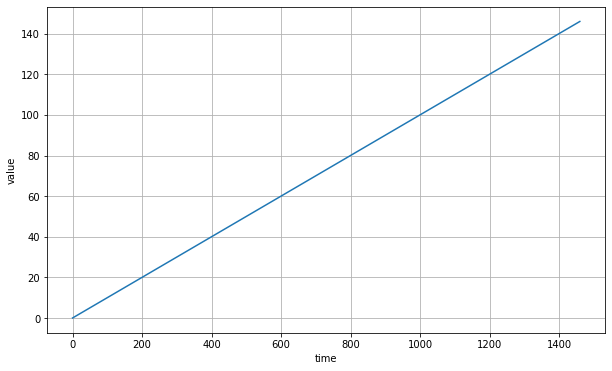

In [7]:
time = np.arange(4*365+1)
baseline = 10
series = trend(time, 0.1)
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [4]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                   np.cos(season_time *2 * np.pi),
                   1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time+phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

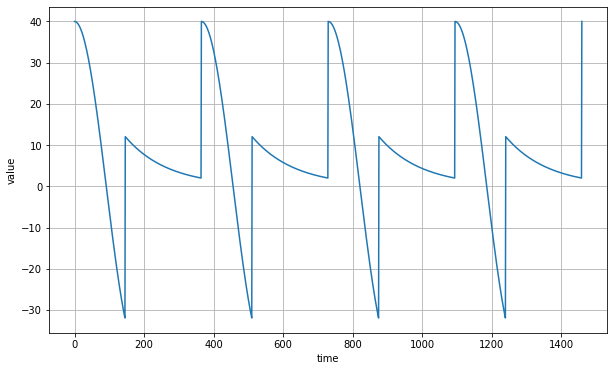

In [10]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

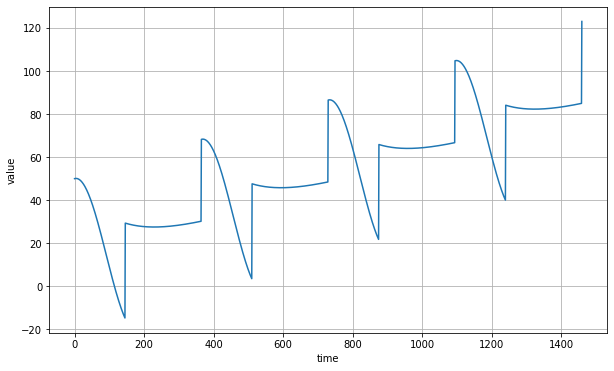

In [13]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [5]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

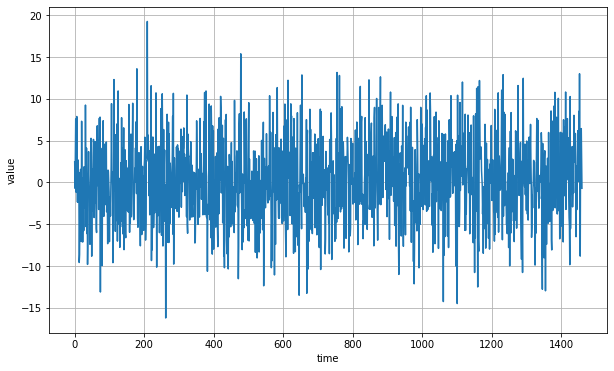

In [16]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

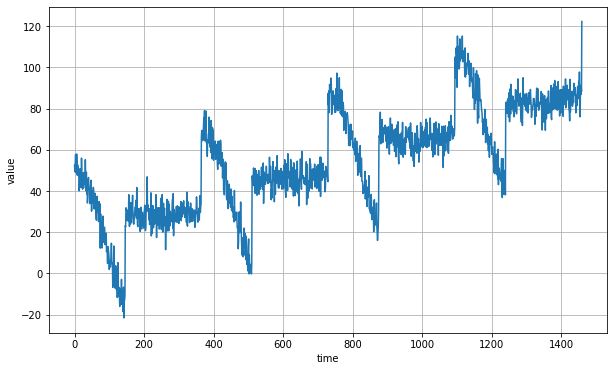

In [17]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [6]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

Autocorrelation, also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of delay. This data has a predictable shape, evenm if the scale is different

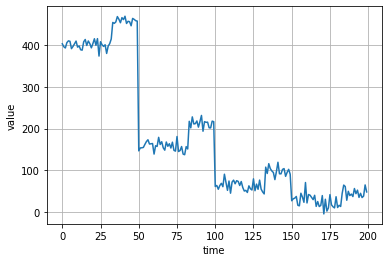

In [19]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

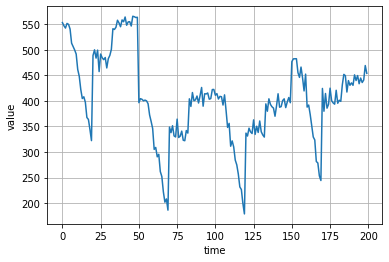

In [20]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

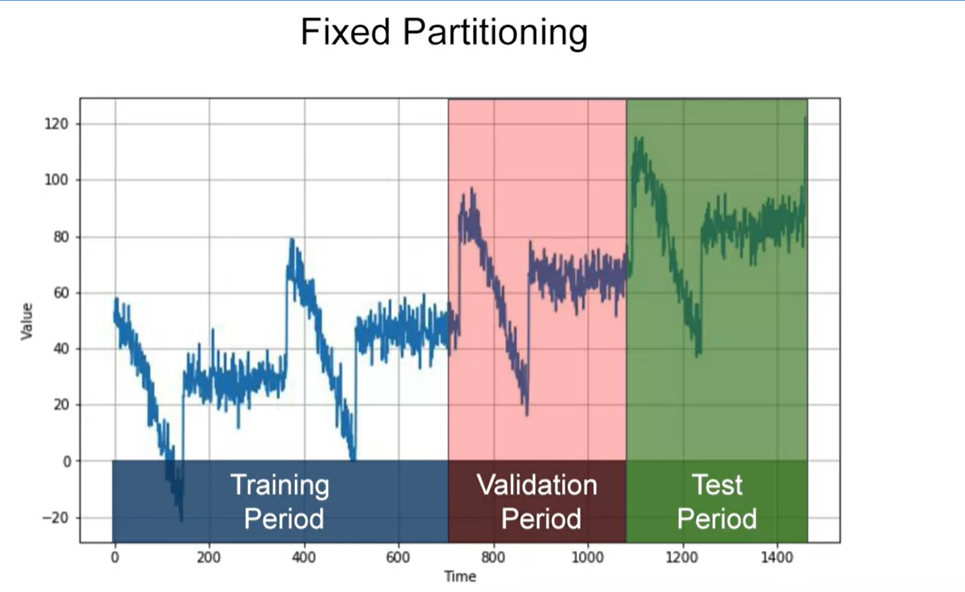

In [21]:
Image.open(r'C:\Users\44788/Desktop\it5.png')

Once confident with the model, introduce the test data with training. this is because this data is the closest values you have to the data you will be predicting.

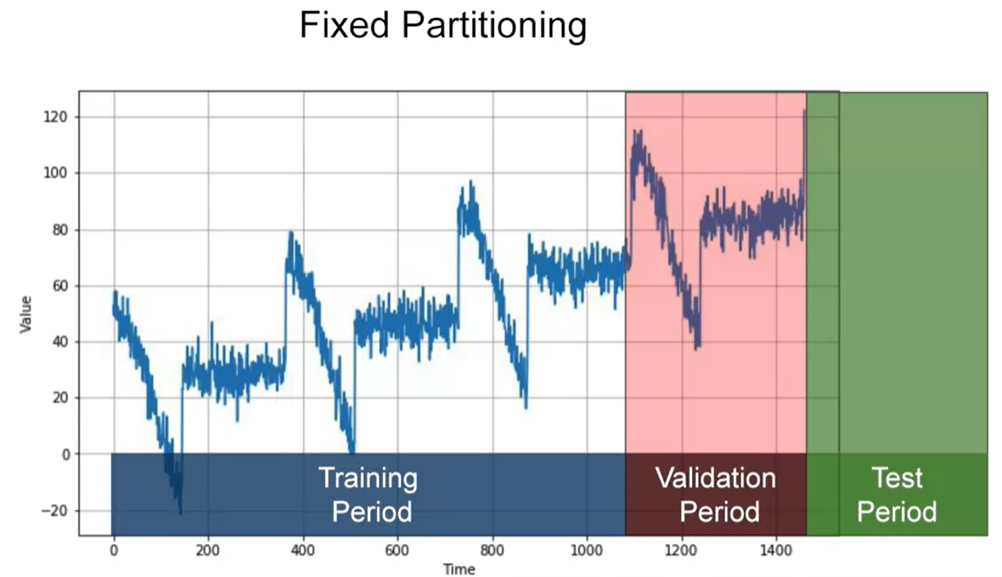

In [22]:
Image.open(r'C:\Users\44788/Desktop\it6.png')

there is also roll forward partitioning, where the training period gets pushed into the validation period on each iteration. where the task is to predict the next data point.

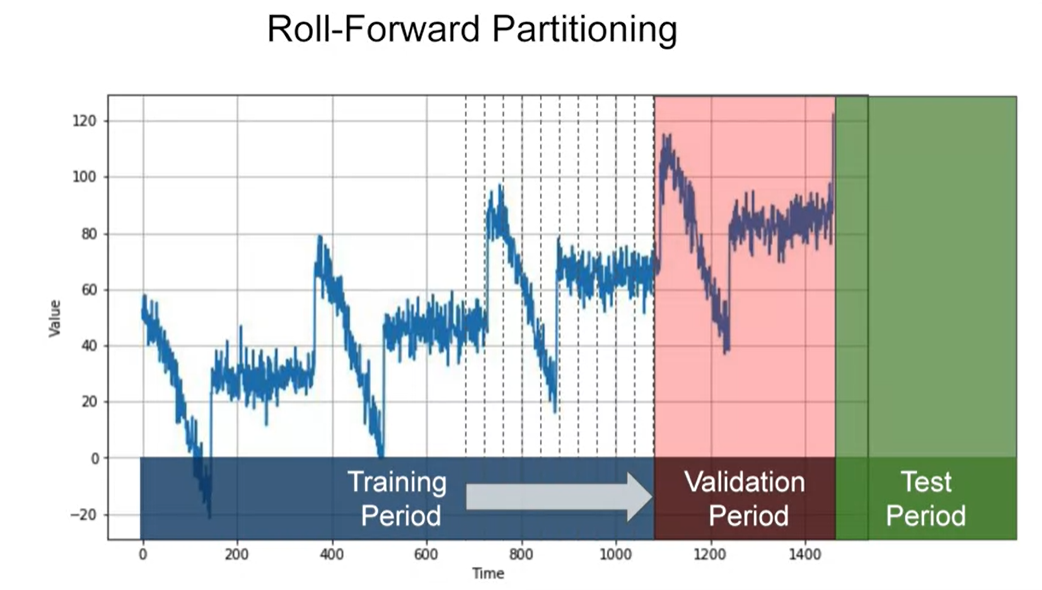

In [23]:
Image.open(r'C:\Users\44788/Desktop\it7.png')

In [ ]:
# metrics to evaluate performance
errors = forcasts - actual
mse = np.square(error).mean() # most common method, square to get rid of negative values
rmse = np.sqrt(mse) # this converts the scale of the error
mae = np.abs(errors).mean() # mean absolute error - this reduces the effect of very large errors
mape = np.abs(errors / x_valid).mean() # mean error between the error and the absolute error

moving average removes the noise potentially, but it does not anticipate trend or seasonality.

with differencing you can remove the seasonaity and trends in the data by minus the value t time t and the value at an earlier period. then perform a moving average on this differenced time series. then add the seasonality and trends back (by adding back the earlier time t) - this should have removed some of the noise. there will still be some noise. this is from the noise from the values added back. therefore, perfrom a weighted average on those values also.

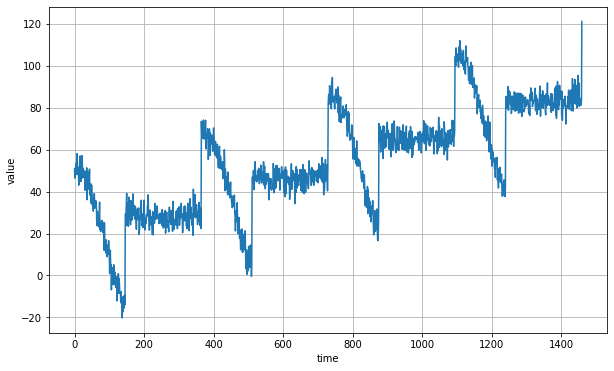

In [8]:
time = np.arange(4*365 +1, dtype='float32')
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 4
series = baseline + trend(time, slope) +seasonality(time, period=365, amplitude=amplitude)
series += white_noise(time, noise_level, seed=43)
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [10]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

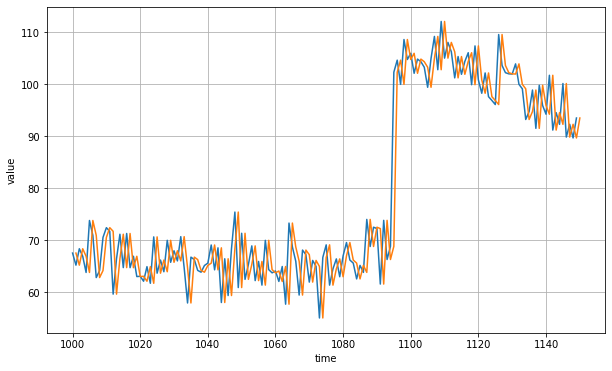

In [12]:
naive_forecast = series[split_time - 1:-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151) # naive forecasting = training data t-1

In [15]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

39.11698
4.585206


In [18]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

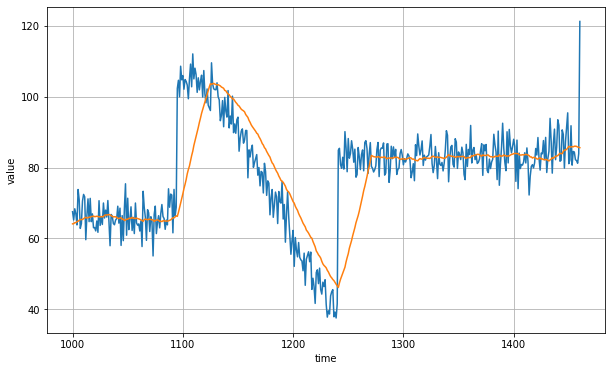

In [21]:
moving_average =  moving_average_forecast(series, 30)[split_time - 30:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_average)

In [22]:
print(keras.metrics.mean_squared_error(x_valid, moving_average).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_average).numpy())

101.80432
6.7400026


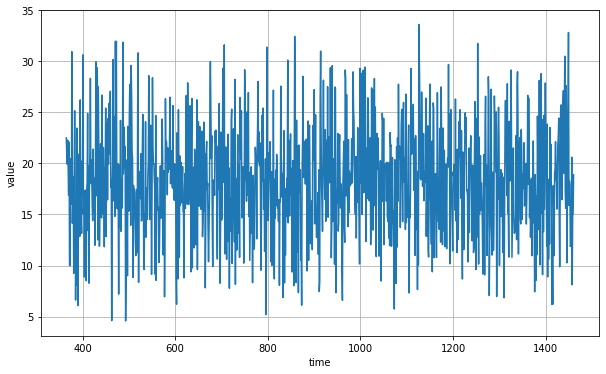

In [34]:
#seasonality is 365 days, differencing:
# raw data + noise
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

In [35]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

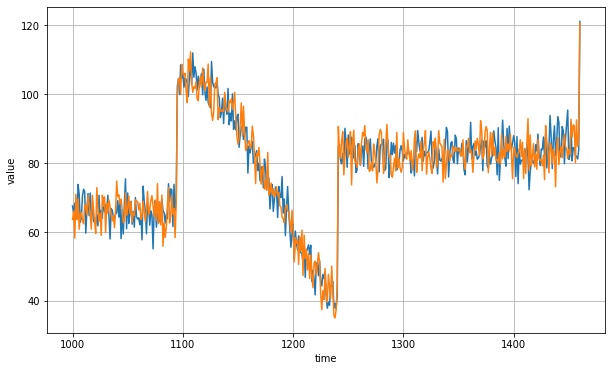

In [36]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [37]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

28.699947
4.35391


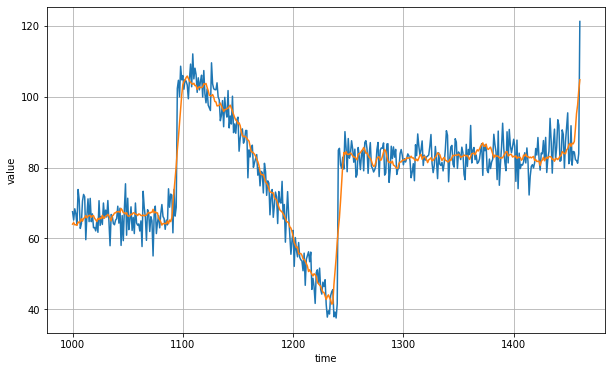

In [38]:
# add in the moving average of the historic values
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [39]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

24.682411
3.7291517
